# Read in model data from Barents and compare with South Cape mooring

In [1]:
import pandas as pd
import datetime
import re
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
import xroms
import pyresample

In [2]:
# Lese inn fil med observasjoner fra Mooring South Cape:

south_cape_df = "/lustre/storeB/project/fou/hi/projects/NorEmso/Observations/moorings/SouthCape/T_S_SouthCape.csv"

In [3]:
# Laste inn modeldata fra Barents 2.5

# Dato av interesse:
my_date = datetime.datetime(2023, 1, 30)
print('Valgt dato: {}'.format(my_date.strftime('%d.%m.%y')))

Valgt dato: 30.01.23


In [49]:
# Laste inn modeldata fra Barents 2.5

barents_path =      'https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_zdepth/barents_zdepth_20240626T00Zm00_AN.nc'
# åpne filen for valgt dato:  
barents_ds = xr.open_dataset(barents_path.format(my_date.strftime('%Y%m%d')))


# Test fil: 

barents_path_test = "https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_zdepth/barents_zdepth_20230130T00Zm00_AN.nc"
# åpne filen for valgt dato:  
barents_dataset_test  = xr.open_dataset(barents_path_test.format(my_date.strftime('%Y%m%d')))

In [5]:
def csv_to_pd(csvfile, lat, lon, start_date, end_date):
    names = ['timestamp', 'ensemble', 'ErrorFlags', 'Temperature', 'Pressure', 'Salinity']

    parse = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S')

    df = pd.read_csv(csvfile, names=names, header=1, usecols=[1, 2, 3, 4, 5, 6], infer_datetime_format=True, parse_dates=["timestamp"], date_parser=parse)

    df['DEPTH'] = np.abs(gsw.z_from_p(df['Pressure'], lat))
    df['LATITUDE'] = lat
    df['LONGITUDE'] = lon
    
    df = df[df['timestamp'] <= end_date]
    df = df[df['timestamp'] >= start_date]
    
    df.rename(columns={'timestamp': 'TIME', 'Temperature': 'TEMP', 'Salinity': 'PSAL'}, inplace=True)
    
    df['TIME'] = pd.to_datetime(df['TIME'])
    return df

In [6]:
# Funksjon som resampler dataen fra datafilen for å bergne gjennomsnitt, minimum, maksimum og en tilfeldig måling per time.
def resample_data(df):
    
    # Sjekk om 'TIME' kolonnen eksisterer
    if 'TIME' not in df.columns:
        raise ValueError("DataFrame does not have a 'TIME' column.")

    df_copy = df.copy()
    
    # Sett 'TIME' som indeks for å resample dataen
    df_copy.set_index('TIME', inplace=True)

    # Resample dataen for å beregne gjennomsnitt, minimum, maksimum og en tilfeldig måling per time
    df_resampled = df_copy.resample('H').agg({
        'TEMP': ['mean', 'min', 'max', 'first'],
        'PSAL': ['mean', 'min', 'max', 'first']
    })

    # Flatten multi-level columns
    df_resampled.columns = ['_'.join(col).strip() for col in df_resampled.columns.values]
    df_resampled.reset_index(inplace=True)

    return df_resampled


In [7]:
#south_cape = csv_to_pd(south_cape_df, lat=76.107, lon=15.967, start_date ="2022-06-29",end_date="2022-06-30")
south_cape = csv_to_pd(south_cape_df, lat=76.107, lon=15.967, start_date ="2023-01-30", end_date="2023-01-31")

south_cape_resampled = resample_data(south_cape)


/modules/rhel8/conda/install/envs/production-10-2022/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in z_from_p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [8]:
south_cape_resampled.head(3)

,TIME,TEMP_mean,TEMP_min,TEMP_max,TEMP_first,PSAL_mean,PSAL_min,PSAL_max,PSAL_first
0,2023-01-30 00:00:00,2.824208,2.7780,2.8832,2.8832,34.885983,34.8828,34.8874,34.8828
1,2023-01-30 01:00:00,2.815542,2.7721,2.8428,2.7721,34.887583,34.8859,34.8902,34.8869
2,2023-01-30 02:00:00,2.857908,2.8268,2.8708,2.8268,34.884992,34.8835,34.8865,34.8865


In [9]:
def plot_SouthCape_pos():

    proj = ccrs.Orthographic(0,45)
    ocean  = cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='none', 
                                          facecolor=cfeature.COLORS['water'])
    land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
        edgecolor='k',
        facecolor=cfeature.COLORS['land'])

    fig, ax = plt.subplots(figsize=(7,7),subplot_kw=dict(projection=proj), ncols=1, nrows = 1)

    # Sett grenser for kartutsnittet  - her fra -30E til 30E, og fra 50N til 90N.
    ax.set_extent([-25, 30, 50, 90], ccrs.PlateCarree())

    # Plott land (farger og kantlinje er satt i variabelen land_10m over)
    ax.add_feature(land_10m, facecolor='burlywood', alpha=0.74 )
    ax.add_feature(ocean, facecolor='lightblue', alpha=0.3)
    
    # Legg på landegrenser
    ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=.5)
    ax.gridlines(zorder=100, draw_labels=True)

    # Plott posisjonen til South Cape mooring
    # X = lon ,  Y = lat, transform = ccrs.PlateCarree forteller cartopy at X og Y er lengde- og breddegrad.
    index_nr = south_cape.index[0]
    ax.scatter([south_cape["LONGITUDE"][index_nr]], [south_cape["LATITUDE"][index_nr]], marker = '*', 
               transform = ccrs.PlateCarree(), label = 'South Cape Mooring', color = 'red')
    
    ax.legend()
    
    return fig, ax



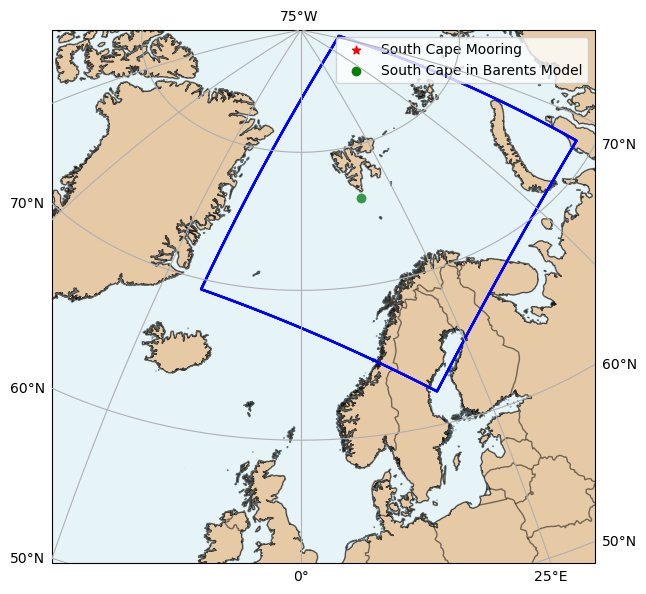

In [12]:
# Lag en "ramme" som viser området modellen dekker:
barents_domain = np.ones_like(barents_dataset_test.lon.values); barents_domain[1:-1, 1:-1] = 0

# Plott område sammen med Stasjon M:
fig, ax = plot_SouthCape_pos()
cs = ax.contour(barents_dataset_test.lon.values, barents_dataset_test.lat.values, barents_domain, colors = 'b', linewidth = 3, transform = ccrs.PlateCarree())
x_pos = 292
y_pos = 444
lat_model = barents_dataset_test.lat.values[y_pos, x_pos]
lon_model = barents_dataset_test.lon.values[y_pos, x_pos]
ax.scatter([lon_model], [lat_model], marker='o', transform=ccrs.PlateCarree(), label='South Cape in Barents Model', color='green')

ax.legend()



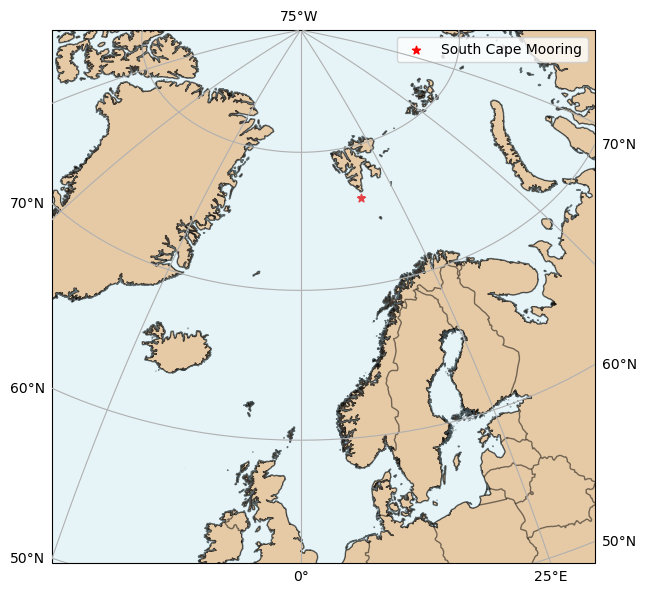

In [14]:
fig, ax = plot_SouthCape_pos()

In [15]:
def get_XYpositions(filename, lons, lats):
    # Open the dataset
    fh  = xr.open_dataset(filename)
    
    x   = np.linspace(0, fh.lat.values.shape[1]-1, fh.lat.values.shape[1])
    y   = np.linspace(0, fh.lat.values.shape[0]-1, fh.lat.values.shape[0])
    xi  = np.zeros_like(fh.lon.values)
    yi  = np.zeros([fh.lon.values.shape[1], fh.lon.values.shape[0]])
    xi[:,:] = x
    yi[:,:] = y
    yi  = np.swapaxes(yi, 1, 0)

    # First I define the wet points of the field as the lon,lat values with mask_rho==1 
    sea_def = pyresample.geometry.SwathDefinition(lons= fh.lon.values[np.where(fh.sea_mask)], lats = fh.lat.values[np.where(fh.sea_mask)])

    # Second, the full grid definiton (our target domain):
    orig_def = pyresample.geometry.SwathDefinition(lons=lons, lats=lats)

    # Then I fill the temperature field by the nearest neighbour approace.
    # Note that only wet points are used as input. 

    # The radius of influence sets a limit (in meters) for how far away a true value can be from the point that will be filled

    ypos = pyresample.kd_tree.resample_nearest(sea_def, yi[np.where(fh.sea_mask)], \
                               orig_def, radius_of_influence=2400)

    xpos = pyresample.kd_tree.resample_nearest(sea_def, xi[np.where(fh.sea_mask)], \
                               orig_def, radius_of_influence=2400)
    return np.array([int(x) for x in xpos]), np.array([int(y) for y in ypos])

In [16]:
target_depths = [300]
locations = {'SouthCape':  {'lat':76.107,    'lon': 15.967}}

dtg = datetime.datetime.now() - datetime.timedelta(days =0 )

In [17]:
for loc, coord in locations.items():
    df = pd.DataFrame({'SITE': [] , 'LAT': [], 'LONG': [], 'DEPTH': [], 'TIME': [] , 'PROG': [], 'CD[deg]': [], 'CV[m/s]': [] })

    locations[loc]['X'], locations[loc]['Y'] = get_XYpositions(barents_path.format( dtg.strftime('%Y/%m'), dtg.strftime('%Y%m%d')), np.array([coord['lon']]), np.array([coord['lat']])) 
    

In [18]:
print(f"Model: Barents")
print("")
for loc, coord in locations.items():
    print(f"Stasjon: {loc}")
    print(f"Latitude: {coord['lat']}, Longitude: {coord['lon']}")
    print(f"X-posisjon: {coord['X']}, Y-posisjon: {coord['Y']}")
    print("")

Model: Barents

Stasjon: SouthCape
Latitude: 76.107, Longitude: 15.967
X-posisjon: [292], Y-posisjon: [444]



In [19]:
south_cape_resampled.head(3)

,TIME,TEMP_mean,TEMP_min,TEMP_max,TEMP_first,PSAL_mean,PSAL_min,PSAL_max,PSAL_first
0,2023-01-30 00:00:00,2.824208,2.7780,2.8832,2.8832,34.885983,34.8828,34.8874,34.8828
1,2023-01-30 01:00:00,2.815542,2.7721,2.8428,2.7721,34.887583,34.8859,34.8902,34.8869
2,2023-01-30 02:00:00,2.857908,2.8268,2.8708,2.8268,34.884992,34.8835,34.8865,34.8865


In [20]:
barents_dataset_test

<xarray.Dataset>
Dimensions:                  (s_rho: 42, s_w: 43, X: 739, Y: 949, depth: 16,
                              time: 24)
Coordinates:
  * X                        (X) float32 2.786e+05 2.811e+05 ... 2.124e+06
  * Y                        (Y) float32 -8.979e+05 -8.954e+05 ... 1.472e+06
  * depth                    (depth) float64 0.0 3.0 10.0 ... 1e+03 2e+03 3e+03
  * time                     (time) datetime64[ns] 2023-01-30 ... 2023-01-30T...
    lat                      (Y, X) float64 69.3 69.3 69.29 ... 71.13 71.11
    lon                      (Y, X) float64 -17.96 -17.89 -17.83 ... 68.84 68.83
Dimensions without coordinates: s_rho, s_w
Data variables: (12/21)
    Cs_r                     (s_rho) float64 ...
    Cs_w                     (s_w) float64 ...
    forecast_reference_time  datetime64[ns] ...
    hc                       float64 ...
    projection_lambert       int32 ...
    AKs                      (time, depth, Y, X) float32 ...
    ...                       ...
    sea_mask                 (Y, X) float64 ...
    temperature              (time, depth, Y, X) float32 ...
    u                        (time, depth, Y, X) float32 ...
    v                        (time, depth, Y, X) float32 ...
    w                        (time, depth, Y, X) float32 ...
    zeta                     (time, Y, X) float32 ...
Attributes: (12/33)
    file:                            /lustre/storeB/project/fou/hi/oper/baren...
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           Barents-2.5km - ROMS
    var_info:                        /home/havis/sea/ROMS/metroms_apps/barent...
    rst_file:                        /lustre/storeB/project/fou/hi/oper/baren...
    ...                              ...
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     BARENTS, ADD_FSOBC, ADD_M2OBC, ALBEDO, A...
    DAinfo_EnKF:                     None
    history:                         Mon Jan 30 06:52:32 2023: ncks -O -d tim...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

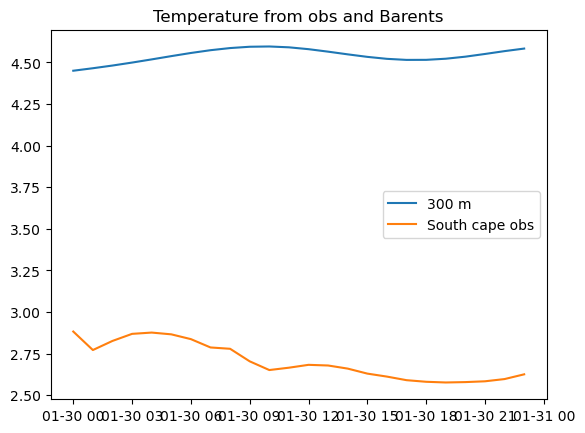

In [21]:
depth_list = [0,3,10,15,25,50,75,100,150,200,250,300,500, 1000, 2000, 3000]

#plt.plot(barents_dataset_test["time"],barents_dataset_test["temperature"][:,  9, 444,292], label = "200 m")
#plt.plot(barents_dataset_test["time"],barents_dataset_test["temperature"][:, 10, 444,292], label = "250 m")
plt.plot(barents_dataset_test["time"],barents_dataset_test["temperature"][:, 11, 444,292], label = "300 m")
plt.plot(south_cape_resampled['TIME'], south_cape_resampled['TEMP_first'], label="South cape obs")
plt.title('Temperature from obs and Barents')
plt.legend()

Text(0.5, 1.0, 'Salinity from obs and Barents')

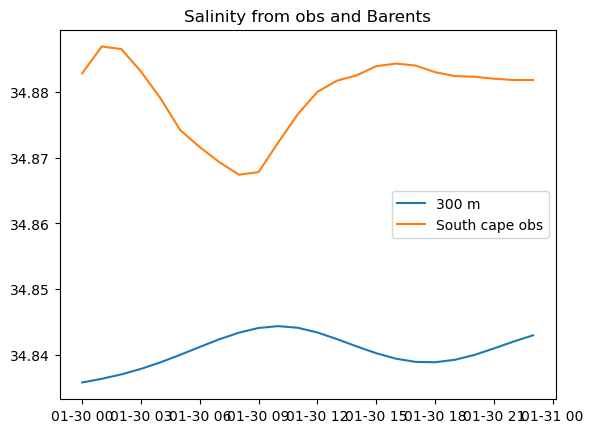

In [22]:
plt.plot(barents_dataset_test["time"],barents_dataset_test["salinity"][:, 11, 444,292], label = "300 m")
plt.plot(south_cape_resampled['TIME'], south_cape_resampled['PSAL_first'], label="South cape obs")
plt.legend()
plt.title('Salinity from obs and Barents')

In [24]:
rmse_first_hour_temp = np.sqrt((diff_temp[0])**2)

In [25]:
rmse_temp = np.sqrt( np.mean(diff_temp**2))
rmse_sal = np.sqrt( np.mean(diff_sal**2))

In [26]:
rmse_temp

1.8402283400931045

In [27]:
rmse_sal

0.039556504711833834

In [28]:
south_cape.head(3)

,TIME,ensemble,ErrorFlags,TEMP,Pressure,PSAL,DEPTH,LATITUDE,LONGITUDE
84005,2023-01-30 00:02:01,84007,20,2.8832,379.709,34.8828,375.401555,76.107,15.967
84006,2023-01-30 00:07:01,84008,20,2.8773,379.715,34.8855,375.407482,76.107,15.967
84007,2023-01-30 00:12:01,84009,20,2.8765,379.715,34.8872,375.407482,76.107,15.967


In [29]:
barents_ds["time"]

<xarray.DataArray 'time' (time: 24)>
array(['2024-06-26T00:00:00.000000000', '2024-06-26T01:00:00.000000000',
       '2024-06-26T02:00:00.000000000', '2024-06-26T03:00:00.000000000',
       '2024-06-26T04:00:00.000000000', '2024-06-26T05:00:00.000000000',
       '2024-06-26T06:00:00.000000000', '2024-06-26T07:00:00.000000000',
       '2024-06-26T08:00:00.000000000', '2024-06-26T09:00:00.000000000',
       '2024-06-26T10:00:00.000000000', '2024-06-26T11:00:00.000000000',
       '2024-06-26T12:00:00.000000000', '2024-06-26T13:00:00.000000000',
       '2024-06-26T14:00:00.000000000', '2024-06-26T15:00:00.000000000',
       '2024-06-26T16:00:00.000000000', '2024-06-26T17:00:00.000000000',
       '2024-06-26T18:00:00.000000000', '2024-06-26T19:00:00.000000000',
       '2024-06-26T20:00:00.000000000', '2024-06-26T21:00:00.000000000',
       '2024-06-26T22:00:00.000000000', '2024-06-26T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2024-06-26 ... 2024-06-26T23:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time
    _ChunkSizes:    1

In [51]:
south_cape_resampled["TIME"]

0    2023-01-30 00:00:00
1    2023-01-30 01:00:00
2    2023-01-30 02:00:00
3    2023-01-30 03:00:00
4    2023-01-30 04:00:00
5    2023-01-30 05:00:00
6    2023-01-30 06:00:00
7    2023-01-30 07:00:00
8    2023-01-30 08:00:00
9    2023-01-30 09:00:00
10   2023-01-30 10:00:00
11   2023-01-30 11:00:00
12   2023-01-30 12:00:00
13   2023-01-30 13:00:00
14   2023-01-30 14:00:00
15   2023-01-30 15:00:00
16   2023-01-30 16:00:00
17   2023-01-30 17:00:00
18   2023-01-30 18:00:00
19   2023-01-30 19:00:00
20   2023-01-30 20:00:00
21   2023-01-30 21:00:00
22   2023-01-30 22:00:00
23   2023-01-30 23:00:00
Name: TIME, dtype: datetime64[ns]

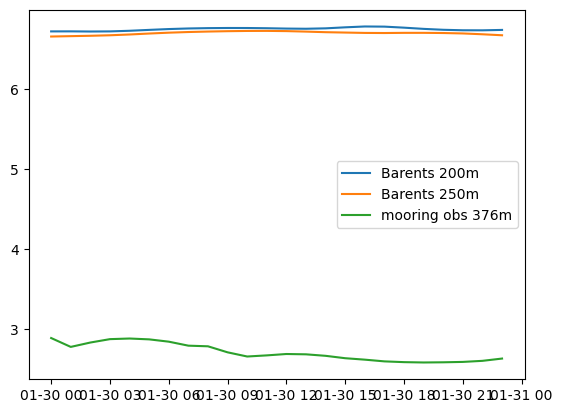

In [39]:
plt.plot(barents_dataset_test["time"], barents_dataset_test["temperature"][:,9,292,444], label = "Barents 200m")
plt.plot(barents_dataset_test["time"], barents_dataset_test["temperature"][:,10,292,444], label = "Barents 250m")
plt.plot(south_cape_resampled["TIME"], south_cape_resampled["TEMP_first"], label = "mooring obs 376m")
plt.title("")
plt.legend()

In [ ]:
ds2['TIME'] = pd.to_datetime(ds2['TIME'])
# Round the TIME column to the nearest hour
ds2['TIME'] = ds2['TIME'].dt.round('H')

ds2['DAY'] = ds2['TIME'].dt.date
print(ds2.head(10))

In [ ]:
# Define a function to extract data for each group
def extract_data_for_group(group):
    date = group['DAY'].iloc[0]  # All rows in the group have the same date
    year = date.strftime('%Y')
    month = date.strftime('%m')
    day = date.strftime('%d')
    
    file_path = f'https://thredds.met.no/thredds/dodsC/sea_norshelf_files/{year}/{month}/norshelf_qck_an_{year}{month}{day}T00Z.nc'
    # Read the file and extract data (assuming file has some structured data)
    try:
        with xr.open_dataset(file_path) as ds:
            # Selcect variables: 
            ds = ds.get(['salt', 'temp'])
            # Here we simulate extracting relevant data from the file for each x, y
            extracted_data = []
            for _, row in group.iterrows():
                x, y = row['X'], row['Y']
                r_time = row['TIME']
                depth = row['DEPTH']
                print(r_time)
                # Data extraction based on x, y, time and s_rho
                # OBS: This is just and example of extraction, have to find the correct ocean_time and s_rho!!!!
                test_tmp = ds.isel(ocean_time=0,s_rho =-1, xi_rho = x, eta_rho = y)
                extracted_data.append(test_tmp.temp.values)
            return extracted_data
    except:
        pass
    